In [490]:
# Import necessary libraries for manipulating files and paths
import os
from pathlib import Path

# Libraries for image processing
import random
from PIL import Image

# Import libraries for data manipulation and visualization
import numpy as np
import matplotlib.pyplot as plt

# Retina mode
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# machine learning libraries
from sklearn.model_selection import train_test_split

# Import libraries for deep learning
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

# Import library for image filtering (specifically Sobel filter)
import kornia

In [428]:
# set up metal performance shaders device for Apple's Metal Framework
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
else:
    print("MPS device not available")
mps_device

device(type='mps')

## Data Exploration

natural_images/cat/cat_0159.jpg
cat
Random image path: natural_images/cat/cat_0159.jpg
Image class: cat
Image height: 337
Image width: 326


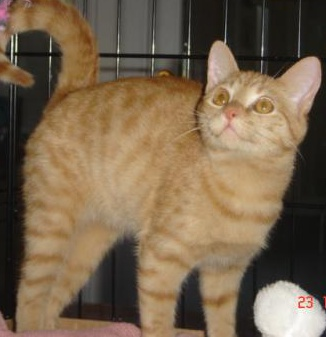

In [429]:
# set seed
random.seed(420)

# 1. get all image paths
dataset_dir = "natural_images"
image_path_list = list(Path(dataset_dir).glob("*/*.jpg"))

# 2. pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. open image
img = Image.open(random_image_path)

# 5. print metadata
print(f"Random image path: {random_image_path}")
print (f"Image class: {image_class}")
print (f"Image height: {img.height}")
print (f"Image width: {img.width}")
img

In [430]:
def walk_through_dir(dir_path):
    """Walks through dir_path returning its contents"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
walk_through_dir(dataset_dir)

There are 8 directories and 1 images in 'natural_images'.
There are 0 directories and 885 images in 'natural_images/cat'.
There are 0 directories and 968 images in 'natural_images/car'.
There are 0 directories and 1000 images in 'natural_images/fruit'.
There are 0 directories and 702 images in 'natural_images/dog'.
There are 0 directories and 986 images in 'natural_images/person'.
There are 0 directories and 843 images in 'natural_images/flower'.
There are 0 directories and 788 images in 'natural_images/motorbike'.
There are 0 directories and 727 images in 'natural_images/airplane'.


(np.float64(-0.5), np.float64(325.5), np.float64(336.5), np.float64(-0.5))

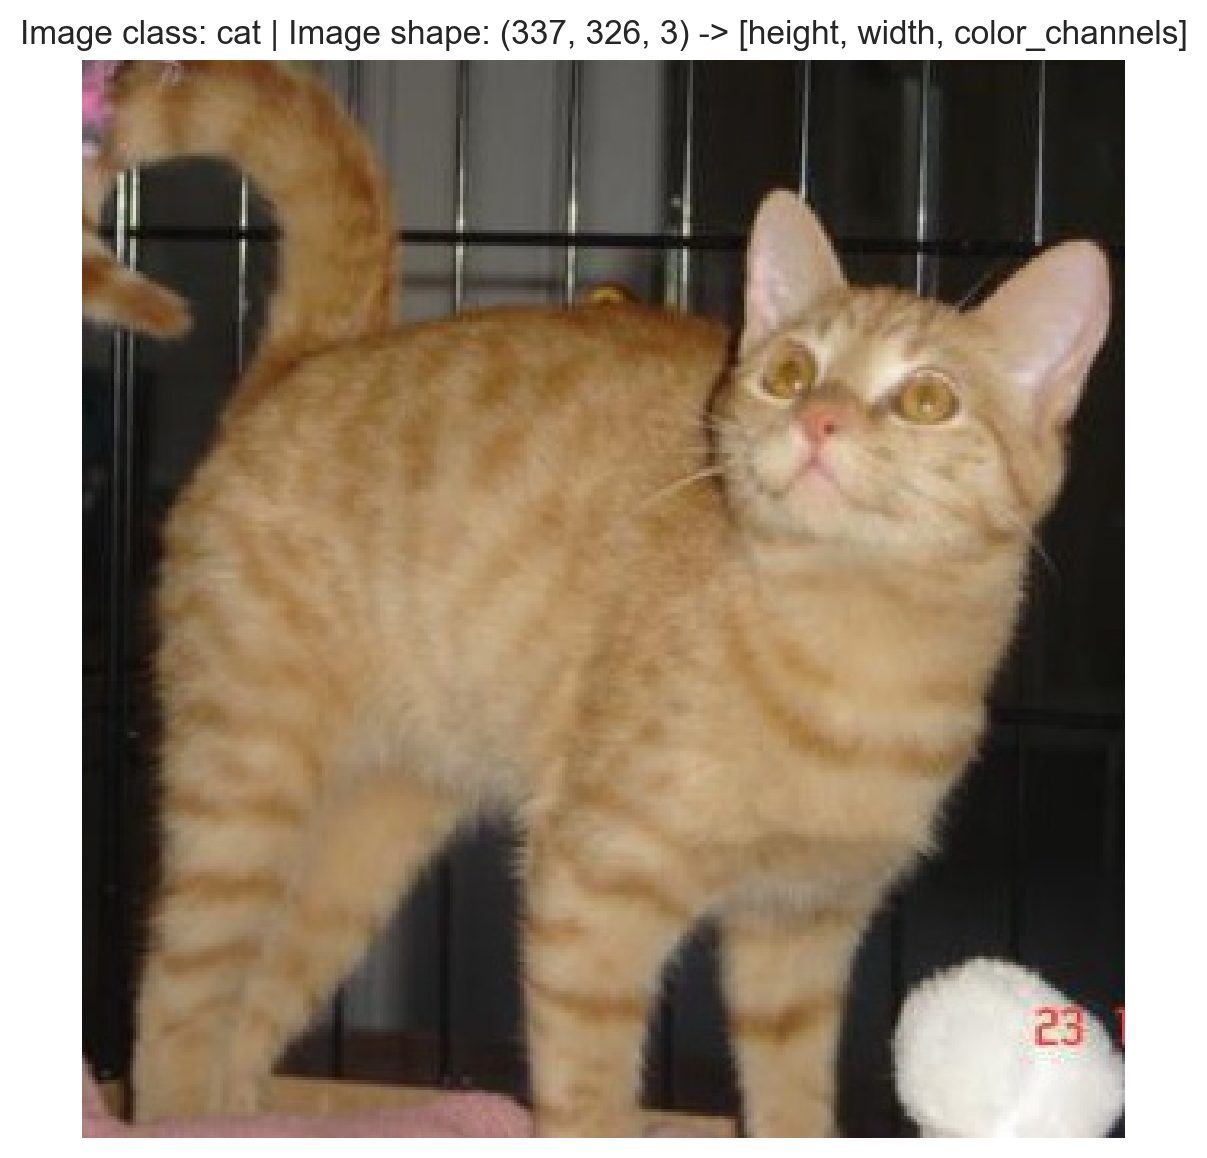

In [431]:
# turn the image into an array
img_as_array = np.asarray(img)

# plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

## Transforming Data

In [432]:
plt.figure(figsize=(10,7))
plt.scatter([Image.open(image_path).height for image_path in image_path_list], [Image.open(image_path).width for image_path in image_path_list], color="#eb0028", alpha=0.5, s=40, edgecolors="#000000", linewidths=0.5)
plt.title("Image height vs. Image width")
plt.xlabel("Image height")
plt.ylabel("Image width")
plt.show()

choosing to resize to 256 x 256 since the above graphs implies significant density of images in this range

In [433]:
data_transform = transforms.Compose([
    # resize our images to 256x256 from observations based on above plot
    transforms.Resize(size=(256,256)),
    # flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [434]:
transformed_img = data_transform(img)
transformed_img.shape

torch.Size([3, 256, 256])

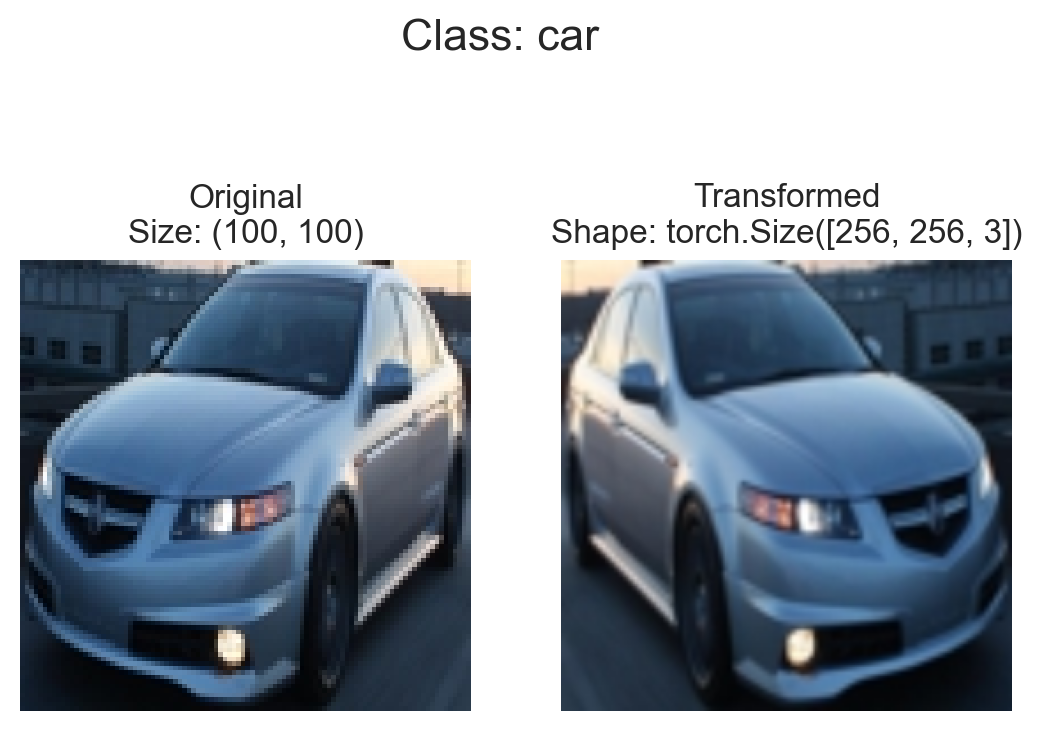

In [435]:
def plot_transformed_images(image_paths:list, transform, n=3, seed=None):
    """
    Selects random images from a path of images and loads/transforms
    them then plots the original vs the transformed version.
    """
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            # Transform and plot target image
            transformed_image=transform(f).permute(1,2,0) # note: we will need to change shape for matplotlib (C,H,W)->(H,W,C)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

## Data Preparation

### Custom Pytorch Dataset class for our data structure

In [436]:
class FiltersDataset(Dataset):
    def __init__(self, root_dir, filter, transform=None):
        self.root_dir = root_dir
        self.filter = filter
        self.transform = transform
        self.original_images = sorted(os.listdir(os.path.join(root_dir, 'original')))
        self.filter_images = sorted(os.listdir(os.path.join(root_dir, self.filter)))

    def __len__(self):
        return len(self.original_images)

    def __getitem__(self, idx):
        original_img_path = os.path.join(self.root_dir, 'original', self.original_images[idx])
        filter_img_path = os.path.join(self.root_dir, self.filter, self.filter_images[idx])

        original_img = Image.open(original_img_path)
        filter_img = Image.open(filter_img_path)

        if self.transform:
            original_img = self.transform(original_img)
            filter_img = self.transform(filter_img)

        return original_img, filter_img

### Data for Sobel Filter

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

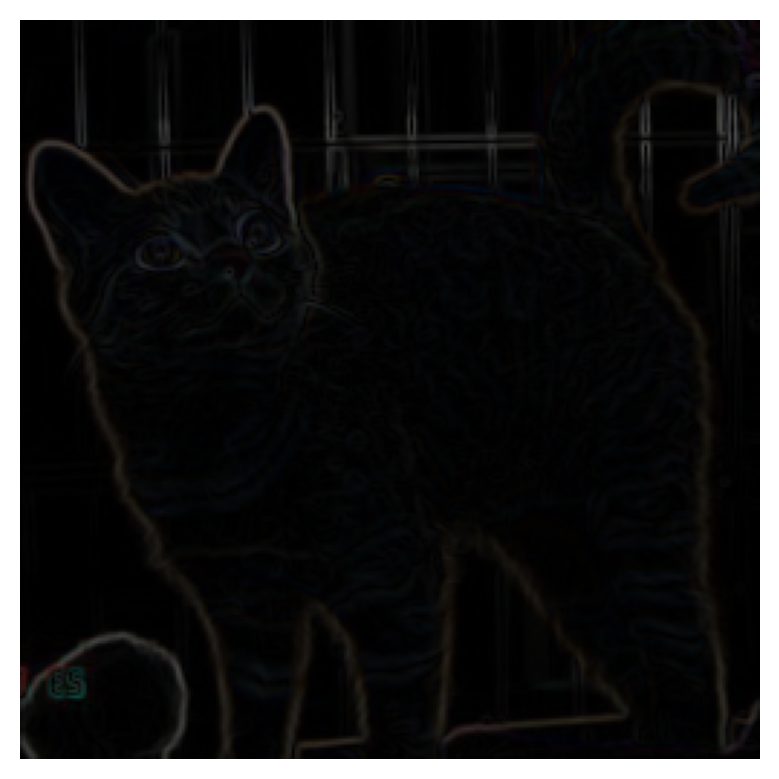

In [437]:
# using a standard image processing library to apply Sobel filter
sobel_filtered_image = kornia.filters.sobel(torch.reshape(transformed_img, (1,3,256,256)), normalized=True, eps=1e-6).reshape(3,256,256)
plt.imshow(sobel_filtered_image.permute(1,2,0))
plt.axis(False)

In [438]:
# make the dataset
X_sobel = []
y_sobel = []
for image_path in image_path_list:
    with Image.open(image_path) as img:
        # transform image
        org_img = data_transform(img)
        X_sobel.append(org_img)
        # Apply Sobel filter
        sobel_filtered_img = kornia.filters.sobel(torch.reshape(org_img, (1,3,256,256)), normalized=True, eps=1e-6).reshape(3,256,256)
        y_sobel.append(sobel_filtered_img)

X_train_sobel, X_test_sobel, y_train_sobel, y_test_sobel = train_test_split(X_sobel, y_sobel, test_size=0.2, random_state=42)

# save the train and test data
for i in range(len(X_train_sobel)):
    transforms.ToPILImage()(X_train_sobel[i]).save(os.path.join("data/sobel_data/train/original", f"X_train_{i}.jpg"))
    transforms.ToPILImage()(y_train_sobel[i]).save(os.path.join("data/sobel_data/train/sobel", f"y_train_{i}.jpg"))
for i in range(len(X_test_sobel)):
    transforms.ToPILImage()(X_test_sobel[i]).save(os.path.join("data/sobel_data/test/original", f"X_test_{i}.jpg"))
    transforms.ToPILImage()(y_test_sobel[i]).save(os.path.join("data/sobel_data/test/sobel", f"y_test_{i}.jpg"))

In [439]:
# Create train and test datasets
train_dataset_sobel = FiltersDataset(root_dir='data/sobel_data/train', filter='sobel', transform=transforms.ToTensor())
test_dataset_sobel = FiltersDataset(root_dir='data/sobel_data/test', filter='sobel', transform=transforms.ToTensor())

# Create dataloaders
batch_size = 32
train_dataloader_sobel = DataLoader(train_dataset_sobel, batch_size=batch_size, shuffle=True)
test_dataloader_sobel = DataLoader(test_dataset_sobel, batch_size=batch_size, shuffle=False)

In [440]:
train_features_batch_sobel, train_labels_batch_sobel = next(iter(train_dataloader_sobel))
train_features_batch_sobel.shape, train_labels_batch_sobel.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32, 3, 256, 256]))

In [478]:
# show a sample
torch.random.manual_seed(420)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
random_idx = torch.randint(0, len(train_features_batch_sobel), size=[1]).item()
img, label = train_features_batch_sobel[random_idx], train_labels_batch_sobel[random_idx]
ax[0].imshow(img.permute(1, 2, 0))
ax[0].set_title("Original Image")
ax[0].axis(False)
ax[1].imshow(label.permute(1, 2, 0))
ax[1].set_title("Sobel Filtered Image")
ax[1].axis(False)
plt.tight_layout()
plt.show()

### Data for Laplacian Filter

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

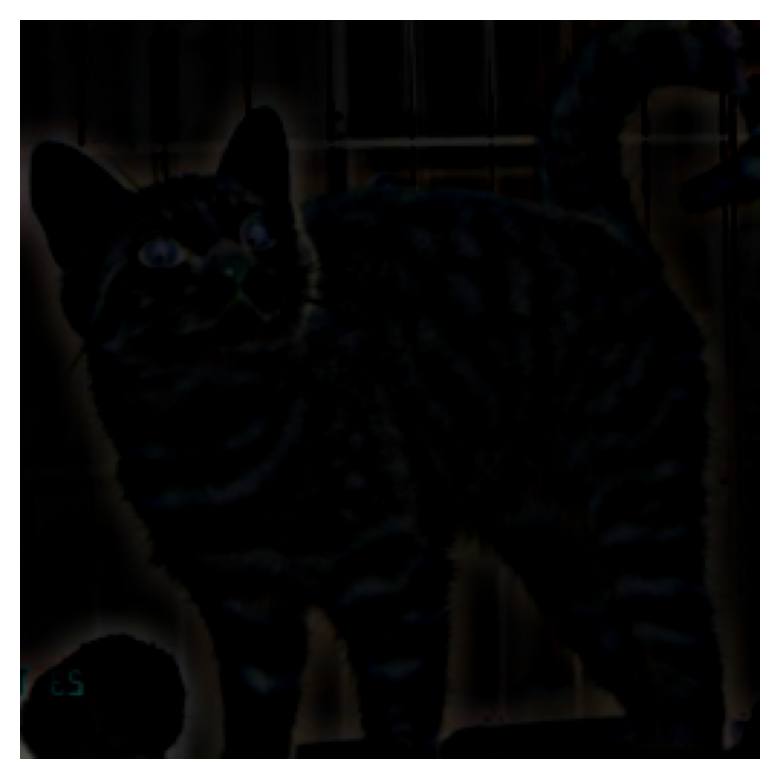

In [442]:
laplacian_filtered_image = kornia.filters.laplacian(torch.reshape(transformed_img, (1,3,256,256)), normalized=True, kernel_size=21).reshape(3,256,256)
laplacian_filtered_image = torch.clamp(laplacian_filtered_image, min=0, max=1)
plt.imshow(laplacian_filtered_image.permute(1,2,0))
plt.axis(False)

In [443]:
# make the dataset
X_laplacian = []
y_laplacian = []
for image_path in image_path_list:
    with Image.open(image_path) as img:
        # transform image
        org_img = data_transform(img)
        X_laplacian.append(org_img)
        # Apply Laplacian filter
        laplacian_filtered_img = kornia.filters.laplacian(torch.reshape(org_img, (1,3,256,256)), normalized=True, kernel_size=21).reshape(3,256,256)
        laplacian_filtered_img = torch.clamp(laplacian_filtered_img, min=0, max=1)
        y_laplacian.append(laplacian_filtered_img)

X_train_laplacian, X_test_laplacian, y_train_laplacian, y_test_laplacian = train_test_split(X_laplacian, y_laplacian, test_size=0.2, random_state=42)

# save the train and test data
for i in range(len(X_train_laplacian)):
    transforms.ToPILImage()(X_train_laplacian[i]).save(os.path.join("data/laplacian_data/train/original", f"X_train_{i}.jpg"))
    transforms.ToPILImage()(y_train_laplacian[i]).save(os.path.join("data/laplacian_data/train/laplacian", f"y_train_{i}.jpg"))
for i in range(len(X_test_laplacian)):
    transforms.ToPILImage()(X_test_laplacian[i]).save(os.path.join("data/laplacian_data/test/original", f"X_test_{i}.jpg"))
    transforms.ToPILImage()(y_test_laplacian[i]).save(os.path.join("data/laplacian_data/test/laplacian", f"y_test_{i}.jpg"))

In [444]:
# Create train and test datasets
train_dataset_laplacian = FiltersDataset(root_dir='data/laplacian_data/train', filter="laplacian", transform=transforms.ToTensor())
test_dataset_laplacian = FiltersDataset(root_dir='data/laplacian_data/test', filter="laplacian", transform=transforms.ToTensor())

# Create dataloaders
batch_size = 32
train_dataloader_laplacian = DataLoader(train_dataset_laplacian, batch_size=batch_size, shuffle=True)
test_dataloader_laplacian = DataLoader(test_dataset_laplacian, batch_size=batch_size, shuffle=False)

In [445]:
train_features_batch_laplacian, train_labels_batch_laplacian = next(iter(train_dataloader_laplacian))
train_features_batch_laplacian.shape, train_labels_batch_laplacian.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32, 3, 256, 256]))

## CNNs for Edge Detection

Given the nature of the task, a shallow CNN with a few convolutional layers should be sufficient. A deeper network might introduce unnecessary complexity and computational overhead for this relatively simple problem.

### The Model

In [457]:
import torch.nn as nn

class EdgeDetection(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.conv3(x)
        return x

# Set input and output channels
input_channels = 3  # RGB color image
output_channels = 3  # Filtered image

In [494]:
# visualizing the model
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("runs/your_experiment")
writer.add_graph(model,train_features_batch_sobel[random_idx].to(mps_device))

In [458]:
def train_model(model, train_iterator, test_iterator, 
                max_epochs=100, early_stopping_patience=5, 
                learning_rate=0.001, save_best=False, save_path=None, 
                device=mps_device):
    """
    Trains the model on the training dataset and evaluates it on the test dataset.
    The model is trained using the Adam optimizer and the L1 loss function. The learning rate
    is scheduled using the CosineAnnealingLR scheduler. Early stopping is used to prevent overfitting.
    
    Parameters:
        model (torch.nn.Module): The model to be trained.
        train_iterator (torch.utils.data.Dataset): The training dataloader.
        test_iterator (torch.utils.data.Dataset): The test dataloader.
        max_epochs (int, optional): The maximum number of epochs to train for. Default is 100.
        early_stopping_patience (int, optional): The number of epochs to wait before stopping
            training if the test loss does not improve. Default is 5.
        learning_rate (float, optional): The initial learning rate for the Adam optimizer. Default is 0.001.
        save_best (bool, optional): Flag to indicate whether to save the model with the best test loss.
            Default is False.
        save_path (str, optional): The file path to save the model to. Only used if save_best is True.
            Default is None.
            
    Returns:
        tuple: A tuple containing the lists of training losses and test losses at each epoch.
    """

    loss_fn = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize early stopping variables
    best_test_loss = float("inf")
    early_stopping_counter = 0

    # Track training and test metrics
    losses = []
    test_losses = []

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

    for epoch in range(max_epochs):
        # Train mode
        model.train()
        epoch_loss = 0.0

        for input_images, target_images in train_iterator:
            input_images, target_images = input_images.to(device), target_images.to(device)

            optimizer.zero_grad()
            output_images = model(input_images)
            loss = loss_fn(output_images, target_images)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Evaluate mode
        model.eval()
        test_loss = 0.0

        for input_images, target_images in test_iterator:
            input_images, target_images = input_images.to(device), target_images.to(device)
            output_images = model(input_images)
            loss = loss_fn(output_images, target_images)
            test_loss += loss.item()

        # Calculate and print epoch losses
        avg_train_loss = epoch_loss / len(train_iterator)
        losses.append(avg_train_loss)
        avg_test_loss = test_loss / len(test_iterator)
        test_losses.append(avg_test_loss)

        print(f"Epoch: {epoch+1}, Training Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

        # Update learning rate
        scheduler.step()

        # Early stopping
        if avg_test_loss < best_test_loss:
            best_test_loss = avg_test_loss
            if save_best:
                torch.save(model.state_dict(), save_path)
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= early_stopping_patience:
            print('Early Stopping')
            break

    return losses, test_losses

In [481]:
def visualize_losses(training_losses, test_losses, save_fig=False, figsize=(10, 6)):
  """
  Visualizes the training and test losses over training iterations.

  Args:
      training_losses (list): List of training losses for each epoch.
      test_losses (list): List of test losses for each epoch.
      save_fig (bool, optional): Flag to save the plot as a PNG image. Defaults to False.
      figsize (tuple, optional): Size of the figure in inches. Defaults to (10, 6).
  """

  # Create a high resolution figure
  plt.figure(figsize=figsize)

  # Plot training loss
  plt.plot(training_losses, label="Training Loss", linewidth=2, color='red')

  # Plot test loss
  plt.plot(test_losses, label="Test Loss", linewidth=2, color='blue')

  # Add labels and title
  plt.xlabel("Epoch", fontsize=14)
  plt.ylabel("Loss", fontsize=14)
  plt.title("Training and Test Loss Over Epochs", fontsize=16)

  # Customize legend and ticks
  plt.legend(loc="upper right", fontsize=12)
  plt.tick_params(labelsize=12)

  # Optional saving
  if save_fig:
    plt.savefig("loss_visualization.png", dpi=300, bbox_inches='tight')

  # Display the plot
  plt.grid(True)
  plt.show()

In [482]:
def visualize_predictions(model, test_iterator, num_images=4, save_fig=False, fig_save_path=None, device=mps_device):
    """
    Visualizes the model's predictions on the test dataset. 
    This function displays the input image, target image, and the corresponding model output 
    for a specified number of images.

    Args:
        model (torch.nn.Module): The model to use for prediction.
        test_iterator (torch.utils.data.Dataset): The test dataset to use for prediction.
        num_images (int, optional): The number of images to visualize. Defaults to 4.
        save_fig (bool, optional): Flag to indicate whether to save the visualization. Defaults to False.
        fig_save_path (str, optional): The file path to save the visualization to. Defaults to None.

    """

    # Get a batch of images from the test dataset
    input_images, target_images = next(iter(test_iterator))
    input_images, target_images = input_images.to(device), target_images.to(device)

    # Predict the output images using the model
    output_images = model(input_images)

    # Detach the images from the computational graph
    input_images = input_images.cpu().detach().numpy()
    output_images = output_images.cpu().detach().numpy()
    target_images = target_images.cpu().detach().numpy()

    # Create the figure and subplots
    fig, axs = plt.subplots(nrows=num_images, ncols=3, figsize=(12, num_images*3))  # Adjusted figsize

    # Plot the input, target, and output images for each image in the batch
    for i in range(num_images):
        axs[i, 0].imshow(input_images[i].transpose(1, 2, 0), vmin=0, vmax=1)
        axs[i, 0].set_title("Input Image")
        axs[i, 1].imshow(target_images[i].transpose(1, 2, 0))
        axs[i, 1].set_title("Target Image")
        axs[i, 2].imshow(output_images[i].transpose(1, 2, 0))
        axs[i, 2].set_title("Model Output")

    # Remove axes labels and tick marks
    for ax in axs.flat:
        ax.set_axis_off()

    # Display the visualization
    plt.tight_layout()  # Improved layout
    plt.show()

    # Save the plot if specified
    if save_fig:
        fig.savefig(fig_save_path)

In [508]:
def evaluate_model(model, test_loader, device=mps_device):
    """
    Evaluates the model's performance on the test set.

    Args:
        model (torch.nn.Module): The trained model.
        test_loader (torch.utils.data.DataLoader): The test data loader.

    Returns:
        None
    """

    model.eval()
    with torch.no_grad():
        intersection = 0
        union = 0
        true_positives = 0
        false_positives = 0
        false_negatives = 0

        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            # Convert to NumPy arrays for easier calculations
            outputs = outputs.cpu().numpy()
            targets = targets.cpu().numpy()

            # Calculate metrics
            intersection += np.sum(np.logical_and(outputs, targets))
            union += np.sum(np.logical_or(outputs, targets))
            true_positives += np.sum(np.logical_and(outputs, targets))
            false_positives += np.sum(np.logical_and(outputs, np.logical_not(targets)))
            false_negatives += np.sum(np.logical_and(np.logical_not(outputs), targets))

        iou = intersection / union
        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        f1_score = 2 * precision * recall / (precision + recall)

        print(f"Intersection over Union: {iou:.4f}") # Measures the overlap between the predicted edge map and the ground truth edge map. Higher is better.
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1_score:.4f}")

### Training and Evaluation for the Sobel Filter

In [479]:
model = EdgeDetection(input_channels, output_channels).to(mps_device)
train_losses, val_losses = train_model(model, 
                                       train_dataloader_sobel, 
                                       test_dataloader_sobel)

Epoch: 1, Training Loss: 0.0311, Test Loss: 0.0215
Epoch: 2, Training Loss: 0.0189, Test Loss: 0.0174
Epoch: 3, Training Loss: 0.0159, Test Loss: 0.0143
Epoch: 4, Training Loss: 0.0132, Test Loss: 0.0123
Epoch: 5, Training Loss: 0.0120, Test Loss: 0.0117
Epoch: 6, Training Loss: 0.0115, Test Loss: 0.0111
Epoch: 7, Training Loss: 0.0109, Test Loss: 0.0105
Epoch: 8, Training Loss: 0.0103, Test Loss: 0.0101
Epoch: 9, Training Loss: 0.0098, Test Loss: 0.0094
Epoch: 10, Training Loss: 0.0091, Test Loss: 0.0090
Epoch: 11, Training Loss: 0.0087, Test Loss: 0.0086
Epoch: 12, Training Loss: 0.0085, Test Loss: 0.0086
Epoch: 13, Training Loss: 0.0082, Test Loss: 0.0081
Epoch: 14, Training Loss: 0.0080, Test Loss: 0.0080
Epoch: 15, Training Loss: 0.0079, Test Loss: 0.0079
Epoch: 16, Training Loss: 0.0078, Test Loss: 0.0078
Epoch: 17, Training Loss: 0.0077, Test Loss: 0.0077
Epoch: 18, Training Loss: 0.0077, Test Loss: 0.0077
Epoch: 19, Training Loss: 0.0078, Test Loss: 0.0075
Epoch: 20, Training L

In [509]:
visualize_losses(train_losses, val_losses, save_fig=True)

In [510]:
visualize_predictions(model, test_dataloader_laplacian, num_images=3, save_fig=True, fig_save_path="sobel_predictions.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.011682494..0.21257807].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0135583..0.22995381].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0135583..0.3168672].


In [511]:
evaluate_model(model, test_dataloader_sobel)

Intersection over Union: 0.7844
Precision: 0.7844
Recall: 1.0000
F1-score: 0.8792


### Training and Evaluation for the Laplacian Filter

In [495]:
model_1 = EdgeDetection(input_channels, output_channels).to(mps_device)
train_losses_1, val_losses_1 = train_model(model_1, 
                                       train_dataloader_laplacian, 
                                       test_dataloader_laplacian)

Epoch: 1, Training Loss: 0.0356, Test Loss: 0.0155
Epoch: 2, Training Loss: 0.0152, Test Loss: 0.0151
Epoch: 3, Training Loss: 0.0149, Test Loss: 0.0150
Epoch: 4, Training Loss: 0.0146, Test Loss: 0.0144
Epoch: 5, Training Loss: 0.0139, Test Loss: 0.0136
Epoch: 6, Training Loss: 0.0134, Test Loss: 0.0134
Epoch: 7, Training Loss: 0.0131, Test Loss: 0.0130
Epoch: 8, Training Loss: 0.0128, Test Loss: 0.0127
Epoch: 9, Training Loss: 0.0126, Test Loss: 0.0125
Epoch: 10, Training Loss: 0.0125, Test Loss: 0.0126
Epoch: 11, Training Loss: 0.0123, Test Loss: 0.0122
Epoch: 12, Training Loss: 0.0122, Test Loss: 0.0121
Epoch: 13, Training Loss: 0.0121, Test Loss: 0.0120
Epoch: 14, Training Loss: 0.0120, Test Loss: 0.0121
Epoch: 15, Training Loss: 0.0120, Test Loss: 0.0120
Epoch: 16, Training Loss: 0.0120, Test Loss: 0.0119
Epoch: 17, Training Loss: 0.0119, Test Loss: 0.0118
Epoch: 18, Training Loss: 0.0119, Test Loss: 0.0118
Epoch: 19, Training Loss: 0.0118, Test Loss: 0.0118
Epoch: 20, Training L

In [512]:
visualize_losses(train_losses_1, val_losses_1, save_fig=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0154607445..0.08312692].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.031613447..0.08312692].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.031613447..0.08312692].


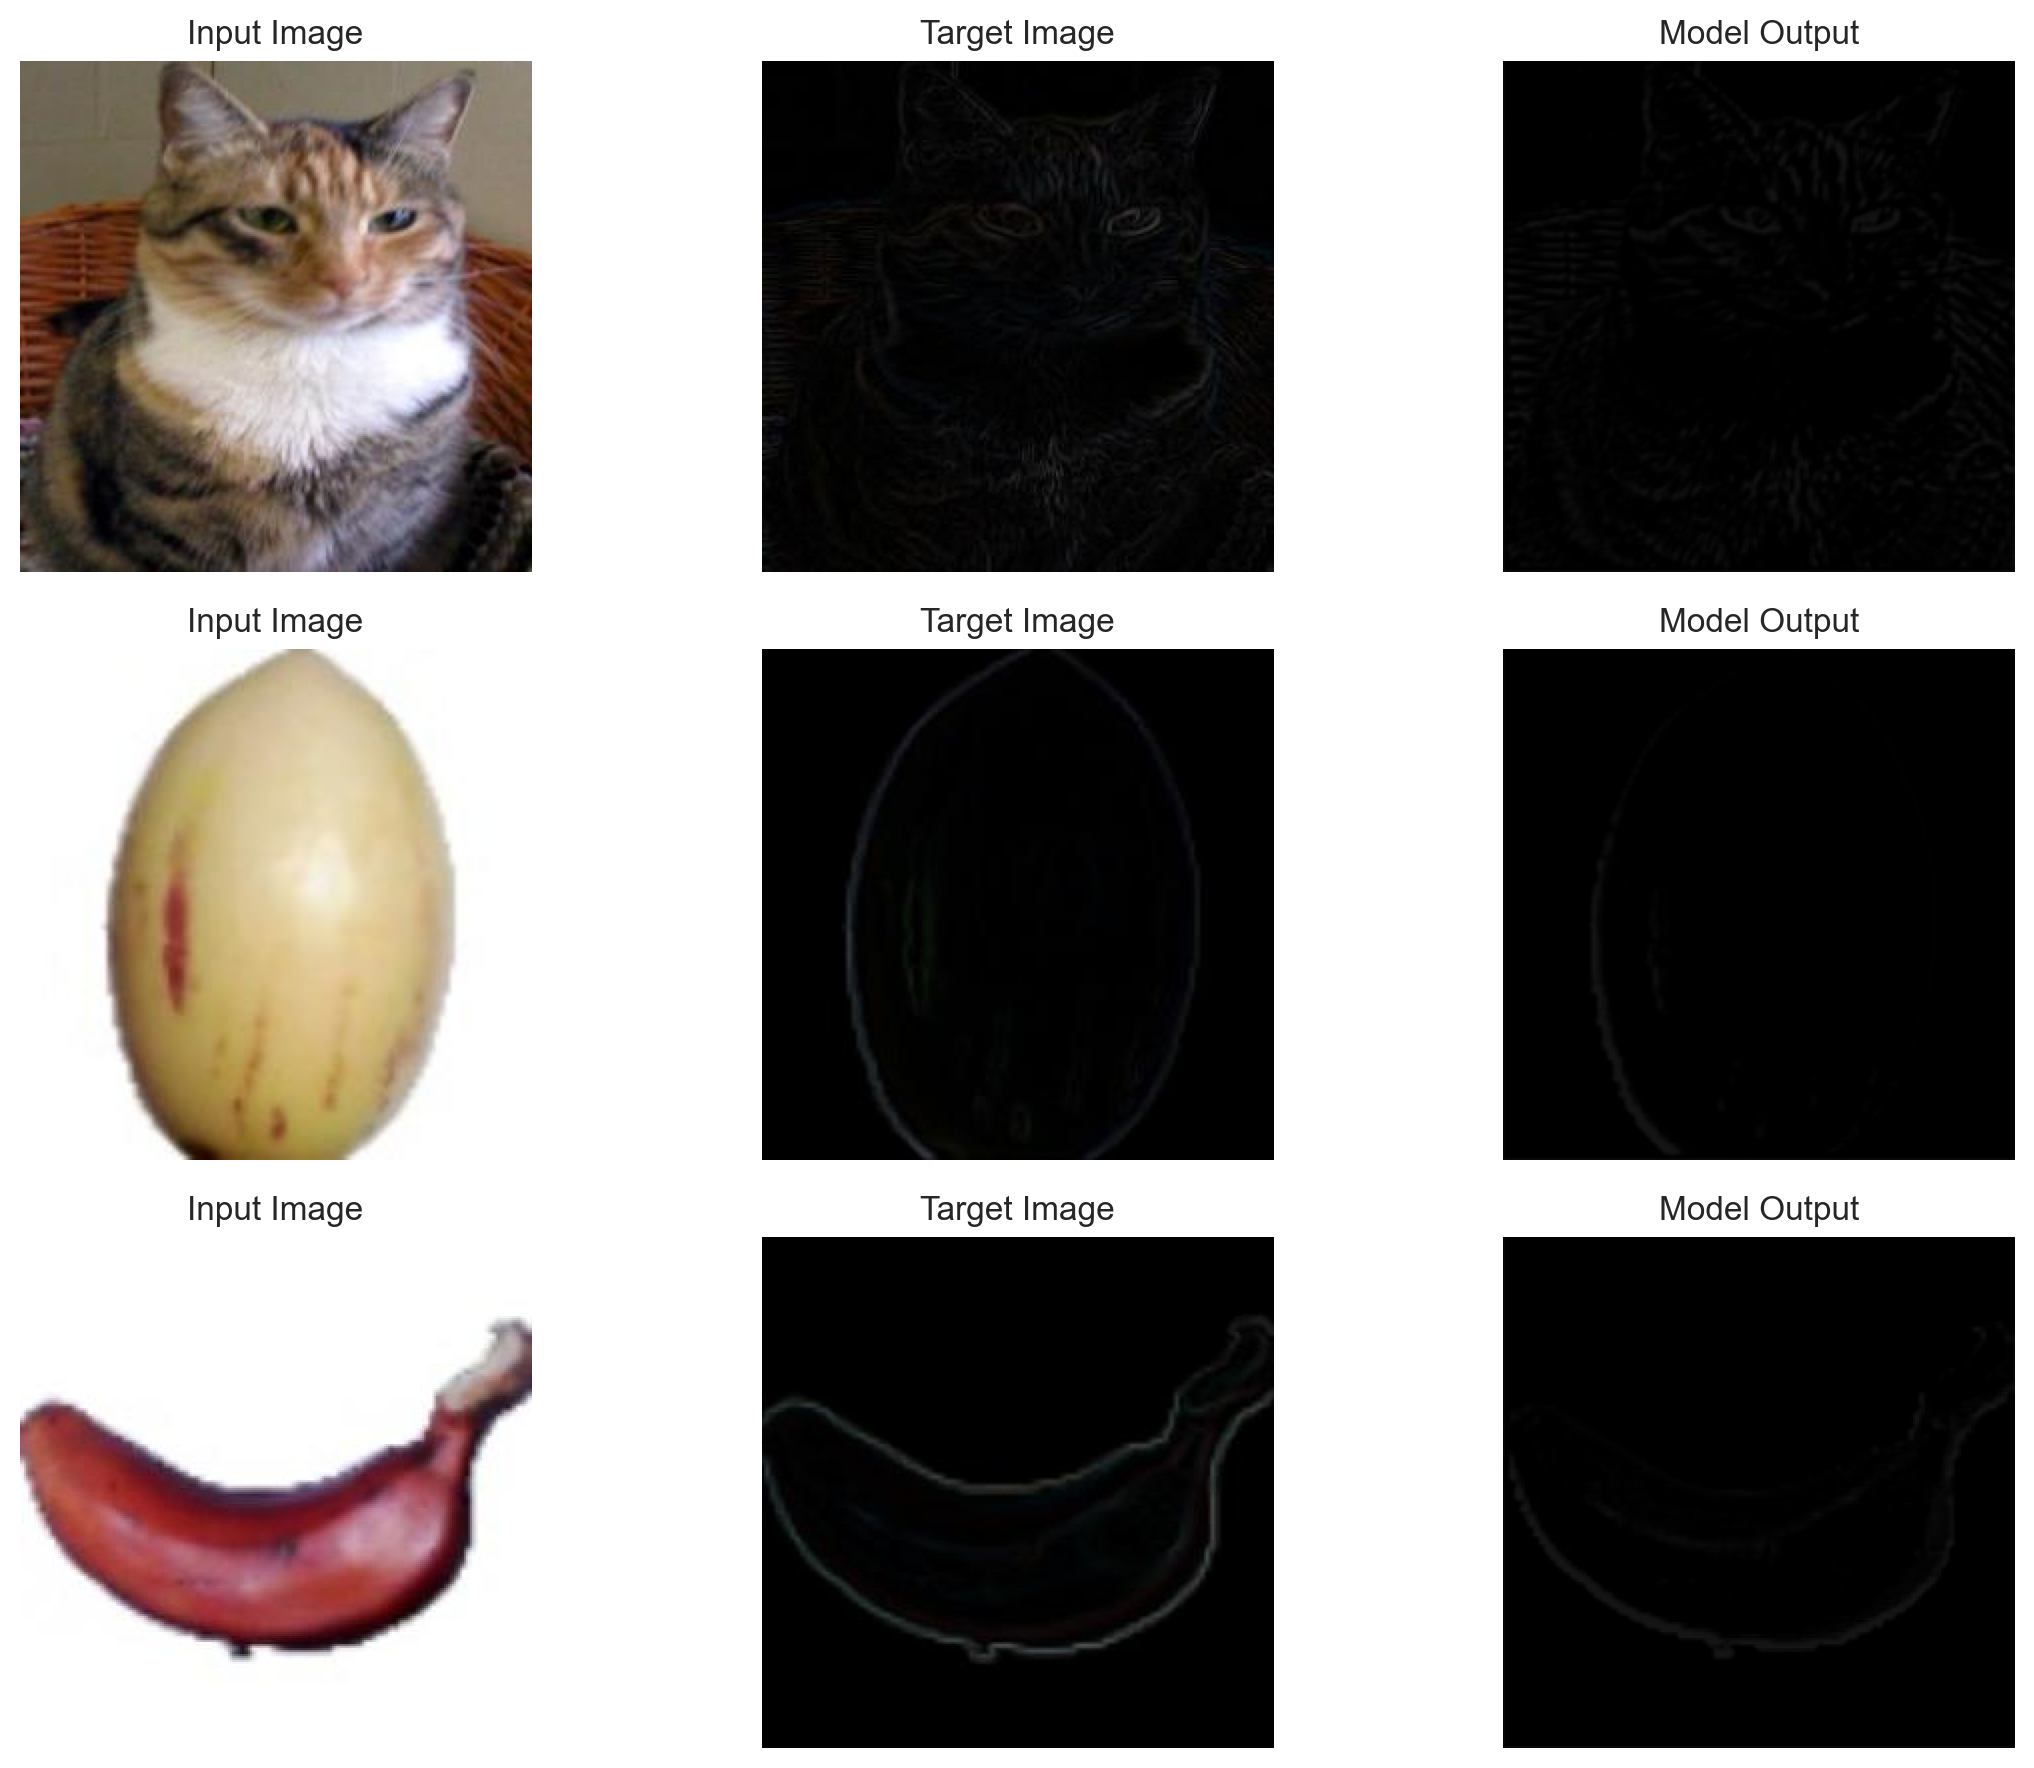

In [513]:
visualize_predictions(model_1, test_dataloader_sobel, num_images=3, save_fig=True, fig_save_path="laplacian_predictions.png")

In [514]:
evaluate_model(model_1, test_dataloader_laplacian)

Intersection over Union: 0.4858
Precision: 0.4858
Recall: 1.0000
F1-score: 0.6539
